# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import nonzero
# plt.rcParams.update({'text.usetex':False})

from scipy import stats

import flavio
import flavio.plots
import pandas as pd

import matplotlib.ticker as tck

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from sklearn.metrics import r2_score, accuracy_score

In [2]:
# Functions
def compute_J_from_vec(vec, wilson_coef=None):
    obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']
    
    if wilson_coef is None:
        print("Setting wilson to sm...")
        #This is the SM
        wilson_coef = flavio.WilsonCoefficients()
        wilson_coef.set_initial({'C9_bsmumu' : 0., 'C10_bsmumu' : 0.}, scale = 100)

    si = {obs: flavio.np_prediction('%s(B0->K*mumu)' % obs, wilson_coef, vec['q2']) for obs in obs_si}

    return compute_J(si, vec['k'], vec['l'], vec['p'])


def compute_J(si, k, l, p):
    ''' Computes the differential branching factor 
    
    si : dict
        dictionary of all S_i terms
    k : float
        theta_k
    l : float
        theta l
    p : float
        phi
    '''

    fl =  3/4*(1 - si['FL']) * (np.sin(k) ** 2) + si['FL'] * (np.cos(k) ** 2) + 1/4 * (1 - si['FL']) * (np.sin(k) ** 2) * np.cos(2*l) - si['FL'] * (np.cos(k) ** 2) * np.cos(2*l)
    s3 = si['S3'] * (np.sin(k) ** 2) * (np.sin(l) ** 2) * np.cos(2 * p)
    s4 = si['S4'] * np.sin(2 * k) * np.sin(2*l) * np.cos(p)
    s5 = si['S5'] * np.sin(2 * k) * np.sin(l) * np.cos(p)
    afb = 4/3 * si['AFB'] * (np.sin(k) ** 2) * np.cos(l)
    s7 = si['S7'] * np.sin(2 * k) * np.sin(l) * np.sin(p)
    s8 = si['S8'] * np.sin(2 * k) * np.sin(2 * l) * np.sin(p)
    s9 = si['S9'] * (np.sin(k) ** 2) * (np.sin(l) ** 2) * np.sin(2 * p)

    return sum([fl, s3, s4, s5, afb, s7, s8, s9])


def compute_J_from_df(df, w):
    obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']
    
    # si = {obs: flavio.np_prediction('%s(B0->K*mumu)' % obs, w, df['q2']) for obs in obs_si}
    si = {}
    for o in obs_si:
        si[o] = df['q2'].apply(
            lambda q2: flavio.np_prediction(f'{o}(B0->K*mumu)', w, q2)
        )
    si = pd.DataFrame(si)
    return compute_J(si, df['k'], df['l'], df['p'])


def format_range(x, a, b):
    ''' given uniform x in range [0,1], ouptut uniform in range [a,b] '''
    return x * (b - a) + a

# Data Import

In [4]:
f_name = 'toy_data_c9_0.0_c10_0.0_2021_12_6_17.csv'
sm = pd.read_csv('data/' + f_name, index_col=0)
sm.rename(columns={'J_comp':'BR_sm'}, inplace=True)
sm['cos_l'] = np.cos(sm['l'])
sm['cos_k'] = np.cos(sm['k'])

In [3]:
obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']

# Reweighting

In [6]:
wc_scenario_8 = flavio.WilsonCoefficients()

c9_busmsm = -0.46
c10_busmsm = 0.46

wc_scenario_8.set_initial({'C9_bsmumu' : c9_busmsm, 'C10_bsmumu' : c10_busmsm}, scale = 100)


sm['scenario_8_w'] = compute_J_from_df(sm, wc_scenario_8) / sm['BR_sm']

In [7]:
wc_scenario_1 = flavio.WilsonCoefficients()

c9_busmsm = -1
c10_busmsm = 1

wc_scenario_1.set_initial({'C9_bsmumu' : c9_busmsm, 'C10_bsmumu' : c10_busmsm}, scale = 100)
sm['scenario_1_w'] = compute_J_from_df(sm, wc_scenario_1) / sm['BR_sm']

# Reweighted distributions

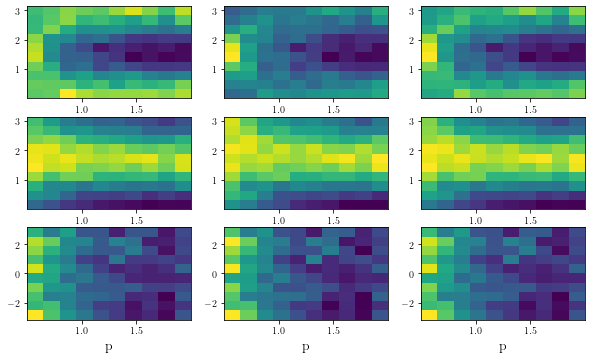

In [22]:
plt.figure(figsize=(10,20))

n_bins = 20
low_q = sm[sm['q2'] < 2][['q2', 'k', 'l', 'p', 'cos_l', 'cos_k', 'BR_sm', 'scenario_8_w', 'scenario_1_w']]

for i in range(1,4):
    plt.subplot(10,3,3*i+1)
    # plt.hist(low_q.iloc[:,i], bins=n_bins, density=True, alpha=0.5)
    # plt.hist(low_q.iloc[:,i], weights=low_q['scenario_8_w'], bins=n_bins, density=True, alpha=0.5)
    # plt.xlabel(low_q.columns[i])
    plt.hist2d(low_q['q2'], low_q.iloc[:,i], density=True)
    plt.xlabel(low_q.columns[i])
    
    plt.subplot(10,3,3*i+2)
    # plt.hist2d(low_q['q2'], low_q.iloc[:,i], density=True)
    # plt.xlabel(low_q.columns[i])
    plt.hist2d(low_q['q2'], low_q.iloc[:,i], weights=low_q['scenario_1_w'], density=True)
    plt.xlabel(low_q.columns[i])
    
    plt.subplot(10,3,3*i+3)
    plt.hist2d(low_q['q2'], low_q.iloc[:,i], weights=low_q['scenario_8_w'], density=True)
    plt.xlabel(low_q.columns[i])

# Checkpoint

In [24]:
sm.to_csv('low_q_with_weights.csv', index=False)

In [4]:
sm = pd.read_csv('low_q_with_weights.csv')

# XGBoost trees

# Easy Classification

In [122]:
garbage_df = pd.DataFrame({
    'a':np.random.uniform(0,1,10000),
    'b':np.random.uniform(0,1,10000),
    'c':np.random.uniform(0,1,10000),
})

normal_df = pd.DataFrame({
    'a':np.append(np.random.normal(-0.2,0.3,10_000), np.random.normal(0.2,0.3,10_000)),
    'l':[0] * 10_000 + [1] * 10_000,
    # 'c':np.random.normal(0,1,10000),
})

normal_df_test = pd.DataFrame({
    'a':np.random.normal(-0.2,0.3,5_000),
    'l':[0] * 5_000,
    # 'c':np.random.normal(0,1,10000),
})

linear_df = pd.DataFrame({
    'a':np.linspace(-1,1,10_000) + np.random.uniform(-0.1,0.1,10_000),
    'b':np.linspace(-1,1,10_000) + np.random.uniform(-0.1,0.1,10_000),
    'c':np.random.uniform(-1,1,10_000),
})

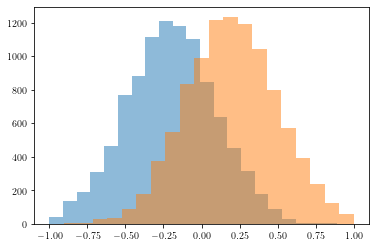

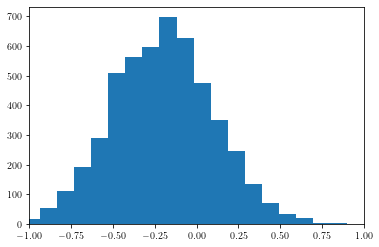

In [51]:
normal_df = normal_df[(normal_df['a'] < 1 ) &  (normal_df['a'] > -1)]
plt.hist(normal_df.loc[normal_df['l'] == 0, 'a'], bins=21, alpha=0.5)
plt.hist(normal_df.loc[normal_df['l'] == 1, 'a'], bins=21, alpha=0.5)
plt.show()
plt.hist(normal_df_test['a'], bins=21)
plt.xlim(-1,1)
plt.show()

## Using ada boost from sklearn

In [79]:
reg = DecisionTreeClassifier(max_depth=5)
ada_boost = AdaBoostClassifier(base_estimator=reg, n_estimators=100)

ada_boost.fit(normal_df[['a']], normal_df['l'])
ada_norm_pred = ada_boost.predict_proba(normal_df_test[['a']])[:,0]


# xgb_bdt = xgb.XGBClassifier(n_estimators=250, subsample=0.4, max_depth=8, learning_rate=0.05)
# xgb_bdt.fit(X_train, Y_train, sample_weight = weights_train)
# test_prediction = xgb_bdt.predict_proba(X_test)[:,1]
# total_test_probs.append(test_prediction)
# total_test_sig.append(Y_test)
# total_test_weights.append(weights_test)


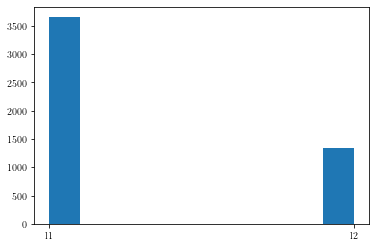

In [80]:
# plt.hist(ada_norm_pred, bins=np.linspace(0.45,0.55,31))
plt.hist(np.where(ada_norm_pred > 0.5, 'l1', 'l2'))
plt.show()

In [81]:
sum(ada_norm_pred > 0.5)/ada_norm_pred.shape[0]

0.7314

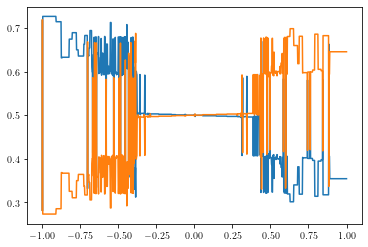

In [82]:
xxx = np.linspace(-1,1,1000).reshape(1000,1)
plt.plot(xxx, ada_boost.predict_proba(xxx))

## using XGB classifier

In [97]:
bdt_clf = XGBClassifier(n_estimators=100, subsample=0.4, max_depth=5, learning_rate=0.03)
bdt_clf.fit(normal_df[['a']], normal_df['l'])
bdt_norm_pred = bdt_clf.predict_proba(normal_df_test[['a']])[:,0]

/Users/oskar/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


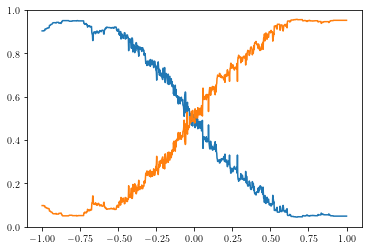

In [98]:
xxx = np.linspace(-1,1,1000).reshape(1000,1)
plt.plot(xxx, bdt_clf.predict_proba(xxx))

In [99]:
sum(bdt_norm_pred > 0.5)/bdt_norm_pred.shape[0]

0.7414

# From Mark

In [ ]:
xgb_bdt = xgb.XGBClassifier(n_estimators=250, subsample=0.4, max_depth=8, learning_rate=0.05)
xgb_bdt.fit(X_train, Y_train, sample_weight = weights_train)
test_prediction = xgb_bdt.predict_proba(X_test)[:,1]
# total_test_probs.append(test_prediction)
# total_test_sig.append(Y_test)
# total_test_weights.append(weights_test)

In [43]:
normal_df

,a,l
0,0.254560,0
1,-0.306793,0
2,0.117737,0
3,-0.313050,0
4,-0.227512,0
...,...,...
19995,-0.071828,1
19996,0.052998,1
19997,-0.341102,1
19998,0.375547,1


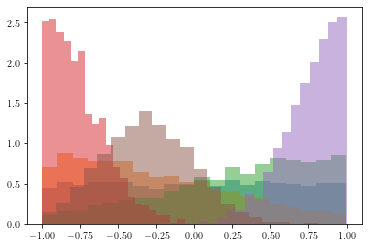

In [216]:
norm_weights_l = stats.distributions.norm.pdf(linear_df['c'],-1,1)
norm_weights_r = stats.distributions.norm.pdf(linear_df['c'],1,1)

norm_l = np.random.normal(-1,0.3,3_000)
norm_l = norm_l[norm_l >= -1]

norm_r = np.random.normal(1,0.3,3_000)
norm_r = norm_r[norm_r <= 1]

norm_mid = np.random.normal(-0.3,0.3,3_000)
norm_mid = norm_mid[(norm_mid <= 1) & (norm_mid >= -1)]

plt.hist(linear_df['c'], bins=20, density=True, alpha=0.5)
plt.hist(linear_df['c'][:5000], bins=20, density=True, alpha=0.5, weights=norm_weights_l[:5000])
plt.hist(linear_df['c'][5000:], bins=20, density=True, alpha=0.5, weights=norm_weights_r[5000:])
plt.hist(norm_l, bins=20, density=True, alpha=0.5)
plt.hist(norm_r, bins=20, density=True, alpha=0.5)
plt.hist(norm_mid, bins=20, density=True, alpha=0.5)

plt.show()

In [217]:
weighted_train_x = linear_df[['c']][:10_000].values
weighted_train_weights = np.array(norm_weights_l[:5_000].tolist() + norm_weights_r[5_000:].tolist())
weighted_train_y = np.array([0] * 5_000 + [1] * 5_000)

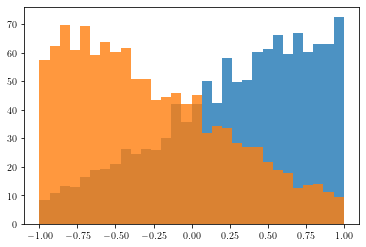

In [220]:
# plt.hist(weighted_train_x, weights=weighted_train_weights, bins=30)
plt.hist(weighted_train_x[weighted_train_y == 1], weights=weighted_train_weights[weighted_train_y == 1], bins=30, alpha=0.8)
plt.hist(weighted_train_x[weighted_train_y == 0], weights=weighted_train_weights[weighted_train_y == 0], bins=30, alpha=0.8)
plt.show()

In [221]:
# reg = DecisionTreeClassifier(max_depth=5)
# boost = AdaBoostClassifier(base_estimator=reg, n_estimators=100)
xgb_clf_weight = XGBClassifier(n_estimators=100, subsample=0.4, max_depth=5, learning_rate=0.03)
xgb_clf_weight.fit(weighted_train_x, weighted_train_y, sample_weight=weighted_train_weights)

/Users/oskar/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [222]:
xgb_weighted_pred_l = xgb_clf_weight.predict_proba(norm_l)[:,0]
xgb_weighted_pred_r = xgb_clf_weight.predict_proba(norm_r)[:,0]
xgb_weighted_pred_mid = xgb_clf_weight.predict_proba(norm_mid)[:,0]

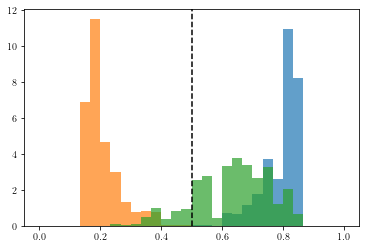

In [232]:
temp_bin = np.linspace(0,1,31)
plt.hist(xgb_weighted_pred_l, density=True, alpha=0.7, bins=temp_bin)
plt.hist(xgb_weighted_pred_r, density=True, alpha=0.7, bins=temp_bin)
plt.hist(xgb_weighted_pred_mid, density=True, alpha=0.7, bins=temp_bin)
plt.axvline(0.5,c='black', linestyle='--')
plt.show()